Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.190300,0.163868,0.942605



Model and tokenizer saved to: ./models/distilbert-financial-sentiment



Classification Report:

              precision    recall  f1-score   support

    negative       0.86      0.91      0.89        56
     neutral       0.97      0.97      0.97       276
    positive       0.92      0.88      0.90       121

    accuracy                           0.94       453
   macro avg       0.92      0.92      0.92       453
weighted avg       0.94      0.94      0.94       453



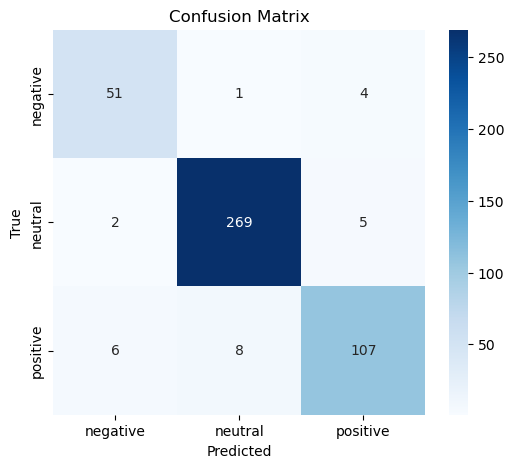

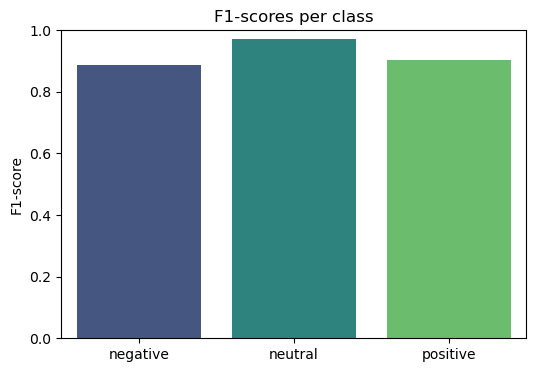

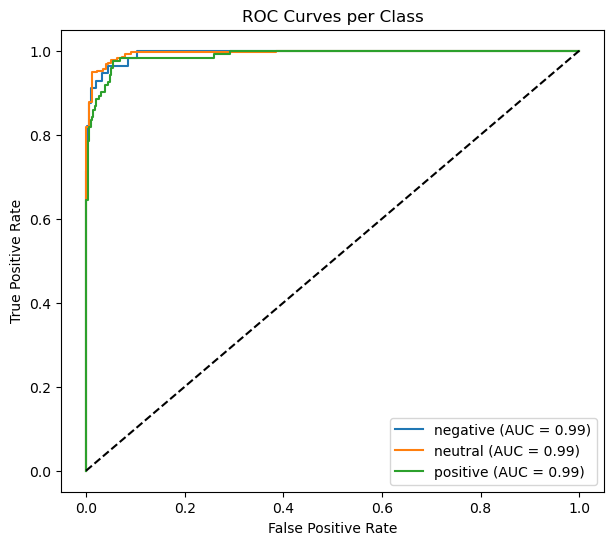


Example Inference → The bank is facing a major restructuring due to rising defaults.
Predicted Sentiment: negative


In [1]:
# ============================================================
# Sentiment Analysis for Banking Texts using DistilBERT
# Dataset: Financial PhraseBank (100% Agreement version)
# Optimized for CPU with metrics & plots (incl. ROC/AUC)
# ============================================================

import warnings
warnings.filterwarnings('ignore')

# Import libraries
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import (
    DistilBertTokenizer, 
    DistilBertForSequenceClassification, 
    Trainer, 
    TrainingArguments
)
import evaluate
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc
)
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

# Use all available CPU threads
torch.set_num_threads(torch.get_num_threads())

# ============================================================
# Load dataset
# ============================================================
df = pd.read_csv(
    "../datasets/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt",
    sep="@", header=None, encoding="latin-1",
    names=["sentence", "sentiment"]
)

# Encode labels
label_map = {"positive": 2, "neutral": 1, "negative": 0}
df["label"] = df["sentiment"].map(label_map)

# Train/test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["sentence"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42
)

# ============================================================
# Tokenization (limit sequence length to 128 for speed)
# ============================================================
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

# ============================================================
# Dataset class for Trainer
# ============================================================
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_ds = SentimentDataset(train_encodings, train_labels)
test_ds = SentimentDataset(test_encodings, test_labels)

# ============================================================
# Load pre-trained DistilBERT model
# ============================================================
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# ============================================================
# Define metrics
# ============================================================
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return metric.compute(predictions=preds, references=labels)

# ============================================================
# Training arguments (CPU-optimized)
# ============================================================
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=20
)

# ============================================================
# Trainer
# ============================================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# ============================================================
# Train model
# ============================================================
trainer.train()

# ============================================================
# Save final model with clear name
# ============================================================
save_path = "./models/distilbert-financial-sentiment"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print(f"\nModel and tokenizer saved to: {save_path}")

# ============================================================
# Evaluate with detailed metrics
# ============================================================
predictions = trainer.predict(test_ds)
y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = predictions.label_ids
y_probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["negative", "neutral", "positive"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Bar chart for F1-scores
report = classification_report(y_true, y_pred, target_names=["negative", "neutral", "positive"], output_dict=True)
f1_scores = [report[label]["f1-score"] for label in ["negative", "neutral", "positive"]]

plt.figure(figsize=(6,4))
sns.barplot(x=["negative", "neutral", "positive"], y=f1_scores, palette="viridis")
plt.title("F1-scores per class")
plt.ylabel("F1-score")
plt.ylim(0,1)
plt.show()

# ============================================================
# ROC / AUC curves for each class
# ============================================================
n_classes = 3
y_true_bin = label_binarize(y_true, classes=[0,1,2])

plt.figure(figsize=(7,6))
for i, label in enumerate(["negative", "neutral", "positive"]):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Class")
plt.legend()
plt.show()

# ============================================================
# Inference on new text
# ============================================================
text = "The bank is facing a major restructuring due to rising defaults."
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)
pred = torch.argmax(outputs.logits).item()

labels = ["negative", "neutral", "positive"]
print("\nExample Inference →", text)
print("Predicted Sentiment:", labels[pred])


In [2]:

# ============================================================
# Inference on new text
# ============================================================
text = "The user  x yes had   bad report for 2022 last month"
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)
pred = torch.argmax(outputs.logits).item()

labels = ["negative", "neutral", "positive"]
print("\nExample Inference →", text)
print("Predicted Sentiment:", labels[pred])



Example Inference → The user  x yes had   bad report for 2022 last month
Predicted Sentiment: negative


In [35]:
text = "The bank is facing a major restructuring due to rising defaults."
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)
pred = torch.argmax(outputs.logits).item()

labels = ["positive", "negative", "neutral"]
print("\nExample Inference →", text)
print("Predicted Sentiment:", labels[pred])


Example Inference → The bank is facing a major restructuring due to rising defaults.
Predicted Sentiment: negative
